# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [ ]:
import os
import random
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread
from sklearn.ensemble import GradientBoostingClassifier

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset

Будем использовать torchvision для работы с данными.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [ ]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)

val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
    
len(train_dataset), len(val_dataset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


(50000, 10000)

In [ ]:
# torch.manual_seed(0)
# train_dataset = Subset(train_dataset, torch.randperm(len(train_dataset))[:5000])
# val_dataset = Subset(val_dataset, torch.randperm(len(val_dataset))[:1000])

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [ ]:
def denormalize_image(image):
    return (image + 1) / 2

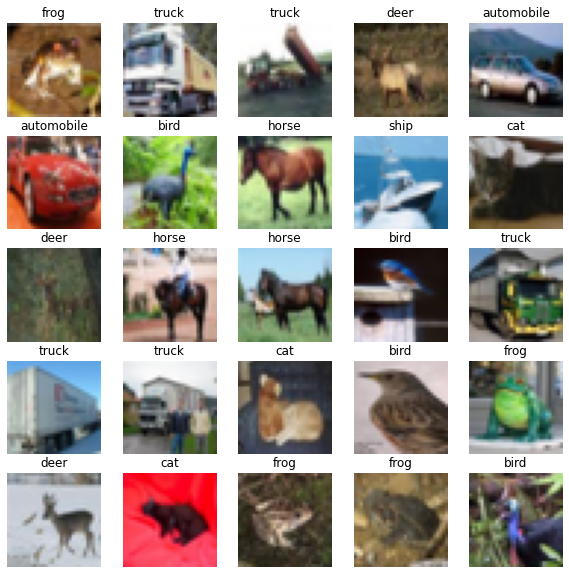

In [ ]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))

for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: 
        break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [ ]:
image.shape

torch.Size([3, 32, 32])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(1563, 10000)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 4, 3, padding=1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),

            nn.Flatten(),
        )
        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        return self.encoder(x)
        ### END SOLUTION

In [ ]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
print('Encoded size:', encoder(noise).shape)
assert encoder(noise).view(-1).shape[0] < 1*3*32*32

Encoded size: torch.Size([1, 256])


In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.decoder = nn.Sequential(
            nn.Unflatten(1, torch.Size([4, 8, 8])),

            nn.Upsample(scale_factor=2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4, 16, 3, padding=1),

            nn.Upsample(scale_factor=2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, 3, padding=1),
        )
        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        return self.decoder(x)
        ### END SOLUTION

In [ ]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32)

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [ ]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [ ]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1203            5.32m
         2           1.9906            4.83m
         3           1.8775            4.85m
         4           1.7825            4.62m
         5           1.6980            4.76m
         6           1.6218            4.59m
         7           1.5534            4.50m
         8           1.4892            4.33m
         9           1.4358            4.25m
        10           1.3821            4.10m
        20           0.9961            3.10m
        30           0.7686            2.06m
        40           0.6105            1.03m
        50           0.4952            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3836

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
encoder.to(device)
decoder.to(device);

cuda:0


In [ ]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)
criterion = nn.MSELoss()

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [ ]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        optim.zero_grad()
        image = image.to(device)
        out = decoder(encoder(image))
        loss = criterion(out, image)
        loss.backward()
        optim.step()
        losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [ ]:
loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1563 [00:00<?, ?it/s]

0.05914087781488361

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [ ]:
@torch.no_grad()
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        image = image.to(device)
        out = decoder(encoder(image))
        loss = criterion(out, image)
        losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [ ]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/10000 [00:00<?, ?it/s]

0.03191488687272649

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [ ]:
def full_train(device, train_loader, val_loader, n_epochs=10, pretrained=False):
    ### BEGIN SOLUTION
    if pretrained:
        import gdown
        gdown.download(id="1sanJ9TH4GO6hY-xMJRbpIqBsEUxZLRrp",
                       output="encoder.weights", 
                       quiet=False)
        gdown.download(id="19a6L9HRTtrI-mHuJS2MKq52myFR6zOYg",
                       output="decoder.weights", 
                       quiet=False)
        encoder = Encoder().to(device)
        decoder = Decoder().to(device)
        encoder.load_state_dict(torch.load("encoder.weights", map_location=torch.device(device)))
        decoder.load_state_dict(torch.load("decoder.weights", map_location=torch.device(device)))
        return encoder, decoder
    else:
    ### END SOLUTION
        encoder = Encoder().to(device)
        decoder = Decoder().to(device)
        params = list(encoder.parameters()) + list(decoder.parameters())
        optim = torch.optim.AdamW(params)
        train_loss = []
        val_loss = []
        for e in trange(n_epochs):
            e_train_loss = train(train_loader, optim, encoder, decoder, device)
            train_loss.append(e_train_loss)
            e_val_loss = eval(val_loader, encoder, decoder, device)
            val_loss.append(e_val_loss)
            print(f'Epoch: {e+1}/{n_epochs}')
            print(f'Train MSE loss: {e_train_loss:.4f}')
            print(f'Validation MSE loss: {e_val_loss:.4f}')
        plt.plot(train_loss, label='train')
        plt.plot(val_loss, label='val')
        plt.legend()
        plt.title('MSE Loss')
        plt.show()

        # save trained wieghts
        torch.save(encoder.state_dict(), "encoder.weights")
        torch.save(decoder.state_dict(), "decoder.weights")

        return encoder, decoder

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1/10
Train MSE loss: 0.0547
Validation MSE loss: 0.0300


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 2/10
Train MSE loss: 0.0317
Validation MSE loss: 0.0266


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 3/10
Train MSE loss: 0.0292
Validation MSE loss: 0.0251


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 4/10
Train MSE loss: 0.0284
Validation MSE loss: 0.0247


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 5/10
Train MSE loss: 0.0277
Validation MSE loss: 0.0238


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 6/10
Train MSE loss: 0.0269
Validation MSE loss: 0.0235


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 7/10
Train MSE loss: 0.0266
Validation MSE loss: 0.0233


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 8/10
Train MSE loss: 0.0261
Validation MSE loss: 0.0242


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 9/10
Train MSE loss: 0.0258
Validation MSE loss: 0.0236


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 10/10
Train MSE loss: 0.0255
Validation MSE loss: 0.0254


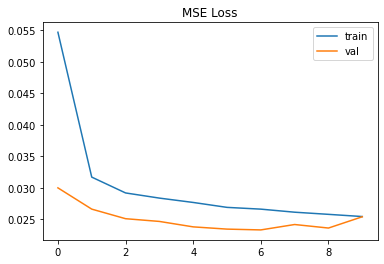

In [ ]:
encoder, decoder = full_train(device, train_loader, val_loader)

In [ ]:
encoder, decoder = full_train(device, train_loader, val_loader, pretrained=True)

Downloading...
From: https://drive.google.com/uc?id=1sanJ9TH4GO6hY-xMJRbpIqBsEUxZLRrp
To: /content/encoder.weights
100%|██████████| 8.63k/8.63k [00:00<00:00, 18.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=19a6L9HRTtrI-mHuJS2MKq52myFR6zOYg
To: /content/decoder.weights
100%|██████████| 8.76k/8.76k [00:00<00:00, 21.8MB/s]


In [ ]:
score = classification_score(encoder, train_dataset, val_dataset, device)
assert score > 0.39, f"{score} is too low!"
score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1162            5.11m
         2           1.9794            4.73m
         3           1.8639            4.69m
         4           1.7645            4.50m
         5           1.6763            4.58m
         6           1.5969            4.99m
         7           1.5272            4.99m
         8           1.4661            4.82m
         9           1.4109            4.71m
        10           1.3563            4.55m
        20           0.9792            3.18m
        30           0.7391            2.10m
        40           0.5776            1.03m
        50           0.4598            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.4194

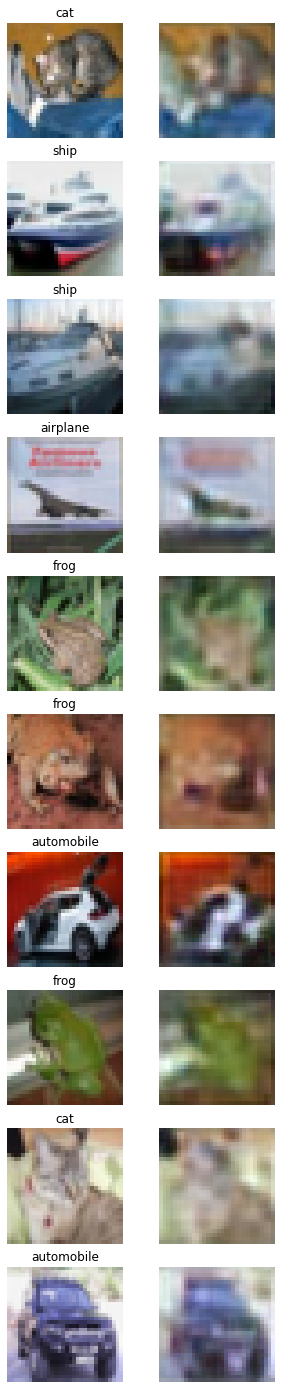

In [ ]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    img_orig = denormalize_image(image)[0].permute(1, 2, 0)
    plt.imshow(img_orig)
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    img_rec = np.clip(denormalize_image(rec)[0].permute(1, 2, 0), 0, 1)
    plt.imshow(img_rec)
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [ ]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    ### BEGIN SOLUTION
    encoder.eval()
    encoder.to(device)
    for image, label in dataloader:
        image = image.to(device)
        label = label.to(device)
        with torch.no_grad():
            emb = encoder(image).view(-1)
            representations[label.item()].append(emb)
    return representations
    ### END SOLUTION

In [ ]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor
assert representations[0][0].shape == (256, )

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+Tr\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [ ]:
def calculate_fid(repr1, repr2):
    ### BEGIN SOLUTION
    from scipy.linalg import sqrtm
    mu_r, mu_g = repr1.mean(axis=0), repr2.mean(axis=0) 
    cov_r, cov_g = np.cov(repr1, rowvar=False), np.cov(repr2, rowvar=False)
    mu_delta = mu_r - mu_g
    covariances = cov_r + cov_g - 2 * sqrtm(cov_r @ cov_g)
    fid = mu_delta @ mu_delta + np.trace(covariances)
    if np.iscomplexobj(fid):
        fid = fid.real
    return fid
    ### END SOLUTION

In [ ]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
        
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print('Cats/dogs distance =', heatmap[3, 5])
print('Cats/deer distance =', heatmap[3, 4])
print('Dogs/deer distance =', heatmap[4, 5])

Cats/dogs distance = 0.05860182319942921
Cats/deer distance = 0.13654954295894184
Dogs/deer distance = 0.15555388732841804


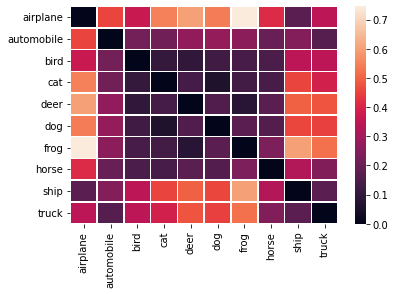

In [ ]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.show()

## Задание 3 (3 балла)

Выберите ваш любимый датасет с кошками и собаками и посчитайте FID между двумя классами на новых данных, используя репрезентацию с уже обученного AE

хинт: если любимого датасета с кошками и собаками нет, можно вырезать эти классы из имажнета

хинт: если вам оооочень не нравятся кошки и собаки, то можете выбрать другие два противоположных класса

---

Нашел рандомный датасет на странице - https://idealo.github.io/imageatm/examples/cats_and_dogs/

In [ ]:
# YOUR CODE HERE
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip
!ls cats_and_dogs_filtered
!ls cats_and_dogs_filtered/train/cats | wc -l
!ls cats_and_dogs_filtered/train/dogs | wc -l

--2023-02-09 09:44:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.3MB/s    in 3.9s    

2023-02-09 09:44:34 (16.7 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

train  validation  vectorize.py
1000
1000


Encoder принимает картинки c shape = (32,32,3), преобразуем датасет. Пример преобразования:

Class = cat


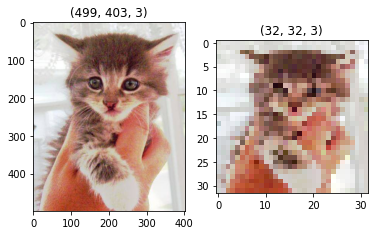

In [ ]:
img = imread('cats_and_dogs_filtered/train/cats/cat.100.jpg')
img_32x32 = cv2.resize(img, (32, 32))

print('Class = cat')
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"{img.shape}")
plt.subplot(1, 2, 2)
plt.imshow(img_32x32)
plt.title(f"{img_32x32.shape}")
plt.show()

In [ ]:
class CatsDogsDataset(Dataset):
    def __init__(self, img_dir, n_imgs=250, transform=None):
        self._items = []
        self._transform = transform

        assert n_imgs <= 1000, "Only 1000 images per class are available!"
        cats_files = os.listdir(f'{img_dir}/cats')
        dogs_files = os.listdir(f'{img_dir}/dogs')
        # 0 - cat, 1 - dog
        for img in cats_files[:n_imgs]:
            self._items.append((os.path.join(img_dir, "cats", img), 0))
        for img in dogs_files[:n_imgs]:
            self._items.append((os.path.join(img_dir, "dogs", img), 1))

    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        img_path, label = self._items[index]
        image = imread(img_path)
        image = np.array(image).astype(np.uint8)
        image = cv2.resize(image, (32, 32))
        # transforms
        if self._transform:
            image = self._transform(image)
        return image, label

In [ ]:
dataset_catsdogs = CatsDogsDataset(img_dir="cats_and_dogs_filtered/train", transform=transform)
loader_catsdogs = DataLoader(dataset_catsdogs, batch_size=1, shuffle=False)

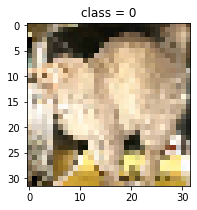

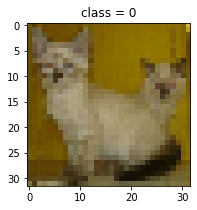

In [ ]:
for i, (im, label) in enumerate(dataset_catsdogs):
    im = im.cpu().numpy().transpose(1, 2, 0)
    im = denormalize_image(im)
    plt.figure(figsize=(3,3))
    plt.imshow(im)
    plt.title(f'class = {label}')
    plt.show()
    if i == 1:
        break

Имеем:
* Датасет на 2 класса по 250 картинок каждый (500 картинок всего)
* Картинки размера 3x32x32
* Прогоняем через энкодер батчами по 1 картинке

In [ ]:
repr_catsdogs = get_representations(loader_catsdogs, encoder, device)

In [ ]:
fid_catsdogs = calculate_fid(
    torch.stack(repr_catsdogs[0], dim=0).cpu().numpy(),
    torch.stack(repr_catsdogs[1], dim=0).cpu().numpy()
)
fid_catsdogs

0.15861104329223918

## Задание 4 (1 балл)

Вы отлично поработали и, скорее всего, в процессе выполнения этих задач у вас появились идеи о том, как еще можно решать подобные проблемы. 

Здесь вы можете описать способы которые вам хотелось бы попробовать если бы у вас было больше времени, или показать статьи которые вы читали, которые решают такие задачи.

Дополнительно, необходимо приложить сюда какой-нибудь смешной мем про генеративные модели за последние два года. Если мем будет не смешным, то баллы придется снять.

---

* FID для cats/dogs на CIFAR10 получилось __~0.06__, а на другом датасете __~0.16__: несмотря на те же самые классы, расстояние между ними получилось заметно выше, почти как расстояние от cats/dogs до deer (0.14 и 0.16 соответственно) на CIFAR10
* Это могло произойти из-за разных причин:
  * разная природа этих данных (могут быть свои особенности, люди в кадре, для этого было бы полезно доучиться на новом датасете, а для регуляризации сделать аугментацию),
  * разная предобработка (для найденного датасета делался простой ресайз, а можно делать центральный квадратный кроп, чтобы сохранять лучше пропорции)
* Касаемо способов извлечения фичей из картинки, здесь много вариантов - использовать предобученные большие модели, увеличивать размерность ботлнека, применять как сверточные подходы, так и визуальные трансформеры

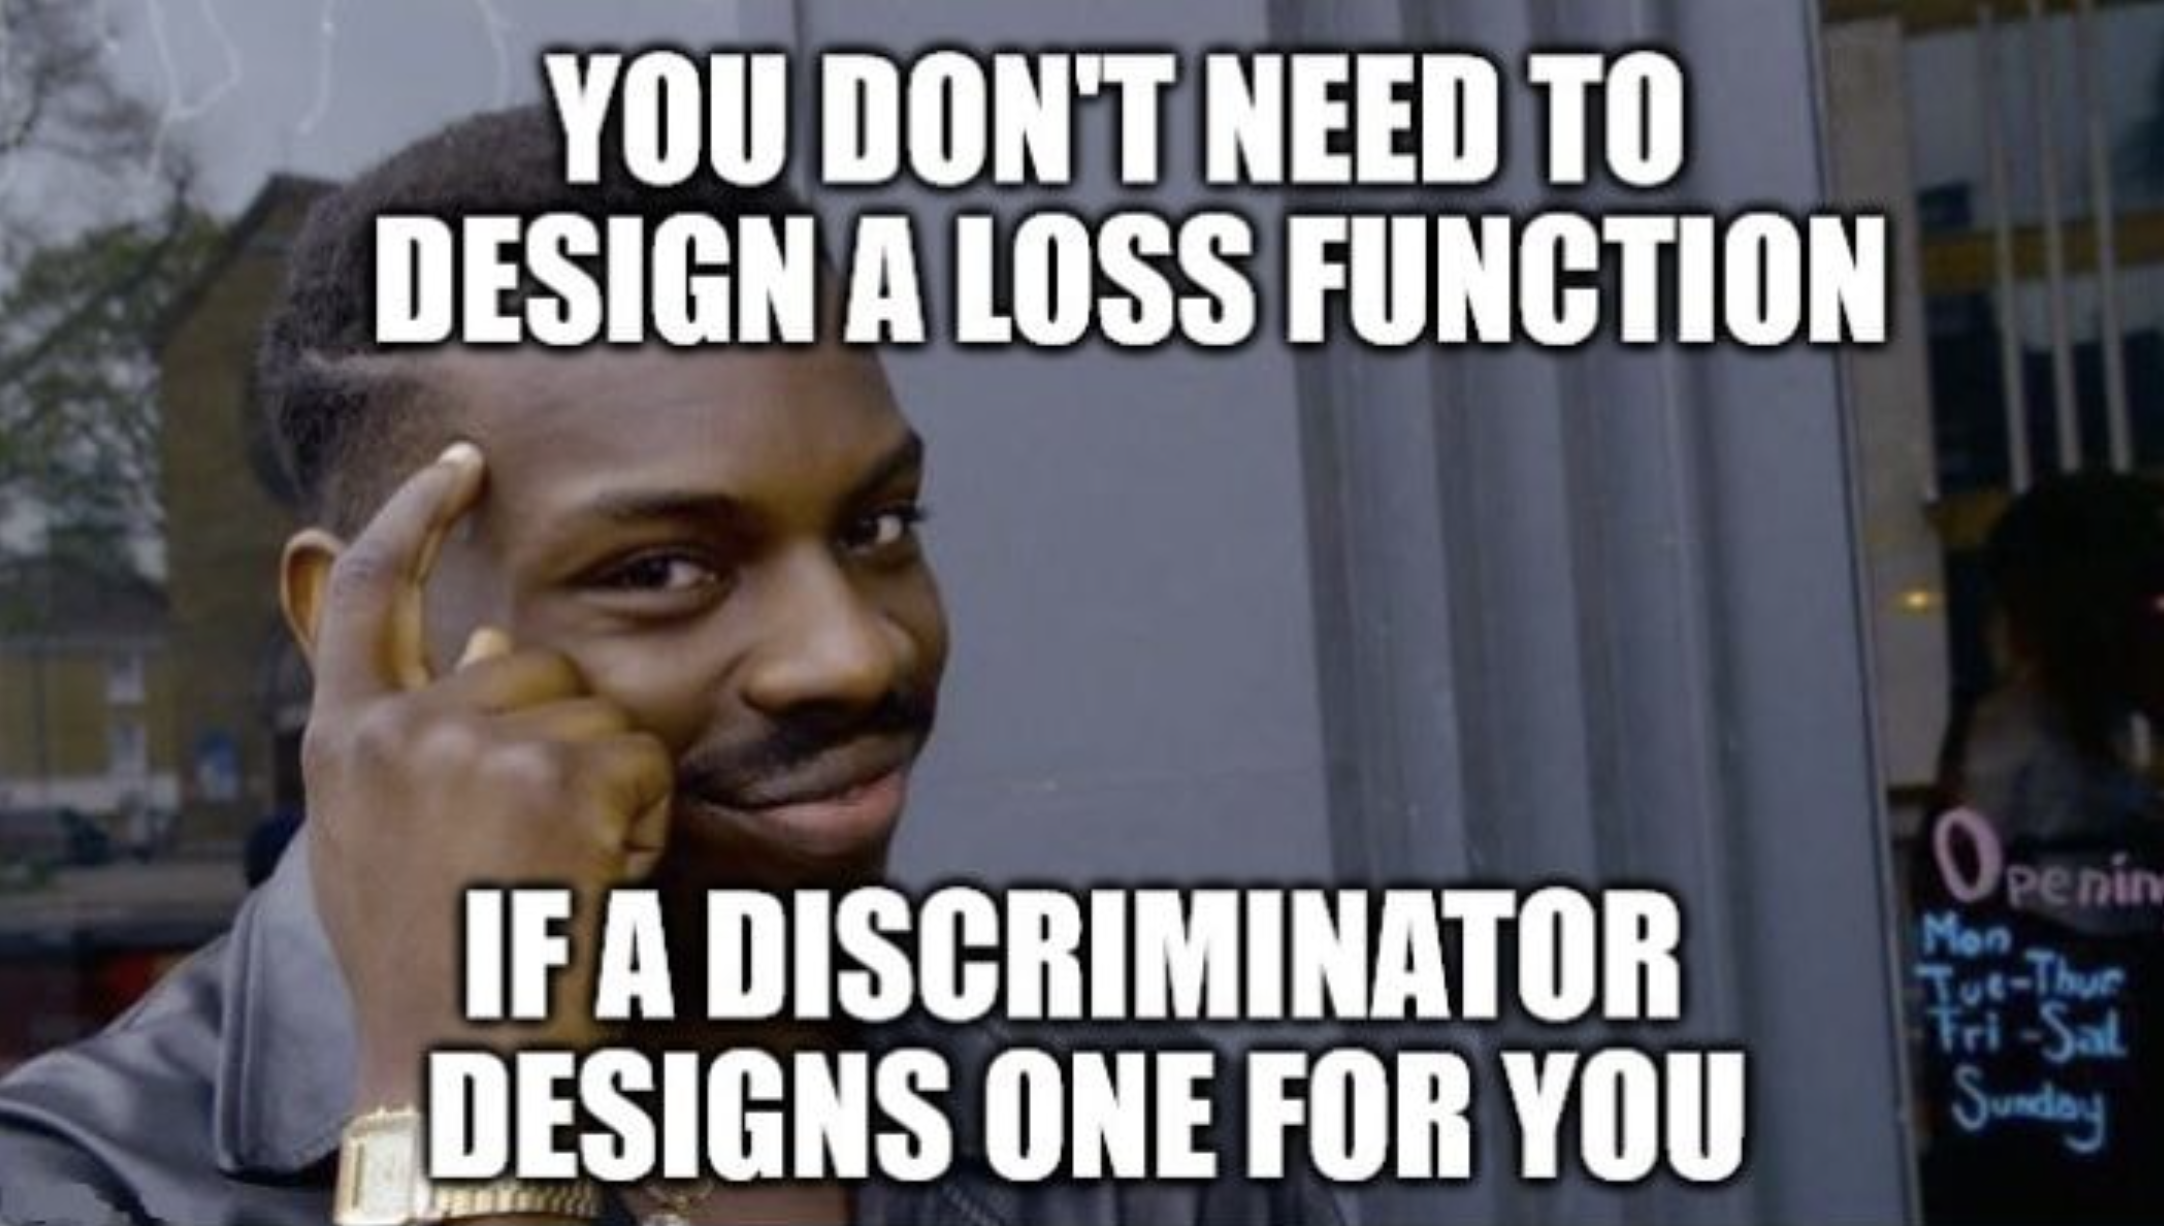